In [77]:
from loadData import load_data
from visualizeData import visualize_data_point, visualize_data_lengths
import numpy as np

In [78]:
TRAIN_DATA_POINTS = 270
TEST_DATA_POINTS = 370

In [79]:
train_data = load_data("data/ae.train", num_data_points=TRAIN_DATA_POINTS)
test_data = load_data("data/ae.test", num_data_points=TEST_DATA_POINTS)

Maximum number of rows of all datapoints: 26
Successfully created a NumPy array with shape: (270, 26, 12)
Maximum number of rows of all datapoints: 29
Successfully created a NumPy array with shape: (370, 29, 12)


In [80]:
train_time_steps, channels = train_data.shape[1:]
test_time_steps = test_data.shape[1]

148


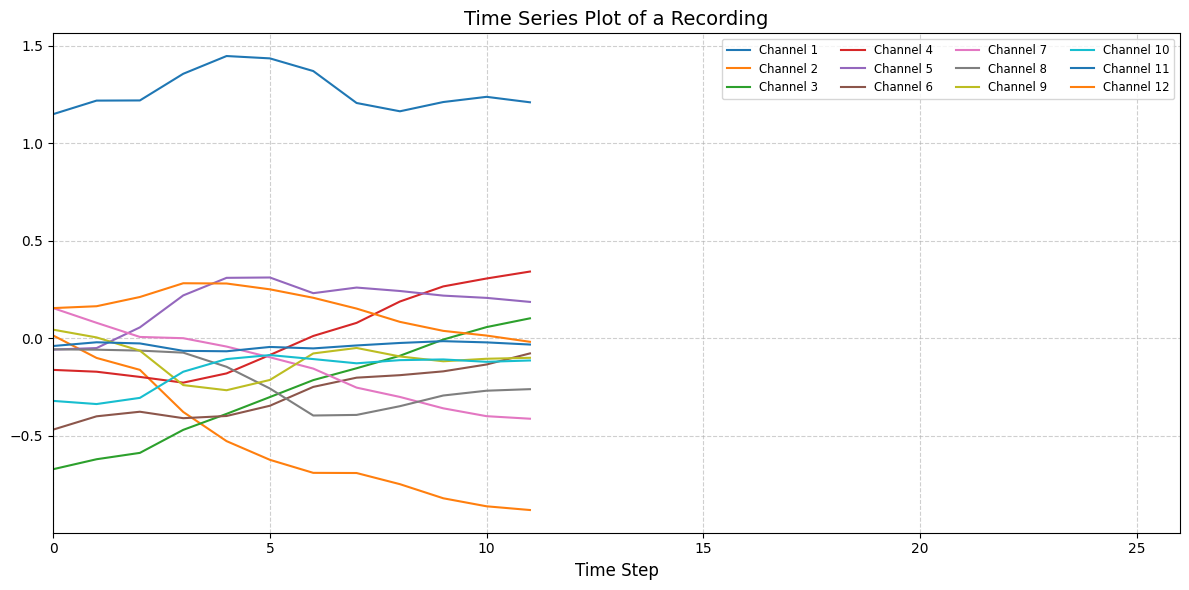

In [81]:
data_point = np.random.randint(0, TRAIN_DATA_POINTS)
print(data_point)
visualize_data_point(train_data[data_point])

In [82]:
def get_time_steps(data):
    time_steps = np.zeros(train_time_steps)

    for data_point in data:
        # list of length max-time-steps lenght (26 for training data) with 1's for
        # non-padded time steps and 0's for all-0-valued (padded) time steps
        mask = [1 if np.count_nonzero(time_step) > 0 else 0 for time_step in data_point]
        time_steps += mask

    return time_steps

In [83]:
def get_pattern_mean(data):
    summed_data = np.sum(data, axis=0)
    time_steps = get_time_steps(data)
    pattern_mean = (summed_data.transpose() / time_steps).transpose()
    return pattern_mean

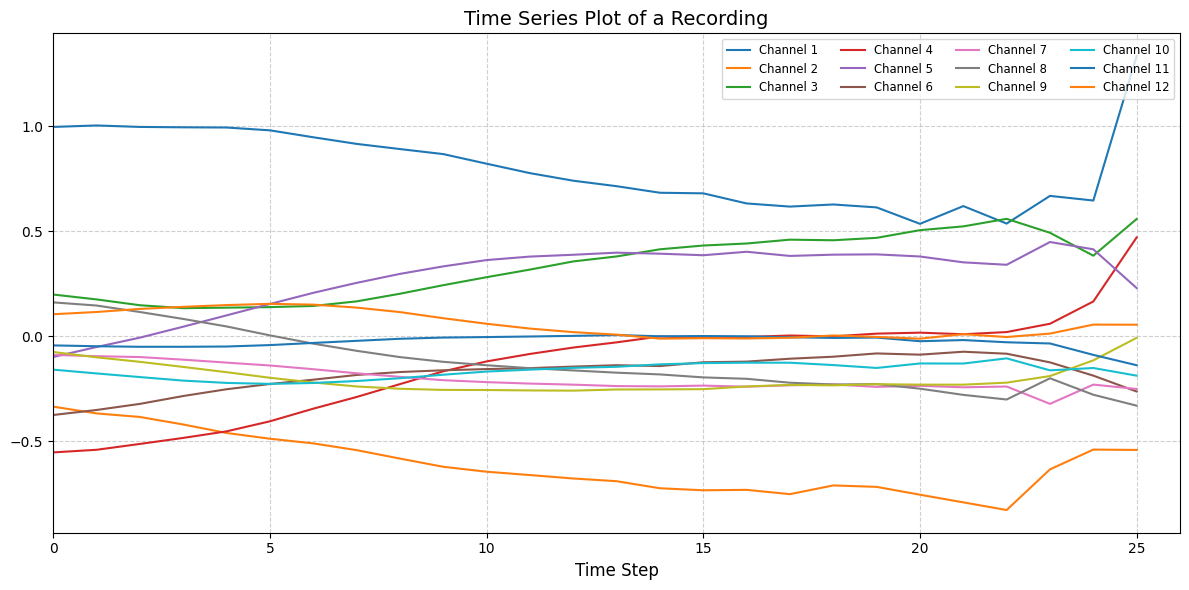

In [84]:
pattern_mean = get_pattern_mean(train_data)
visualize_data_point(pattern_mean)

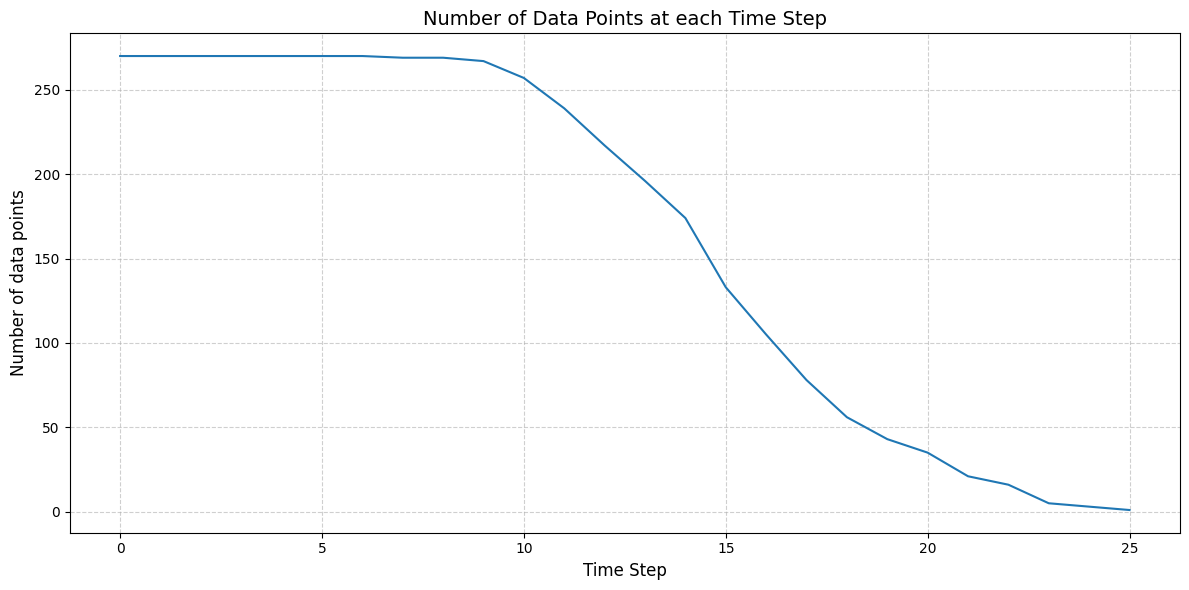

In [85]:
time_steps = get_time_steps(train_data)
visualize_data_lengths(time_steps)

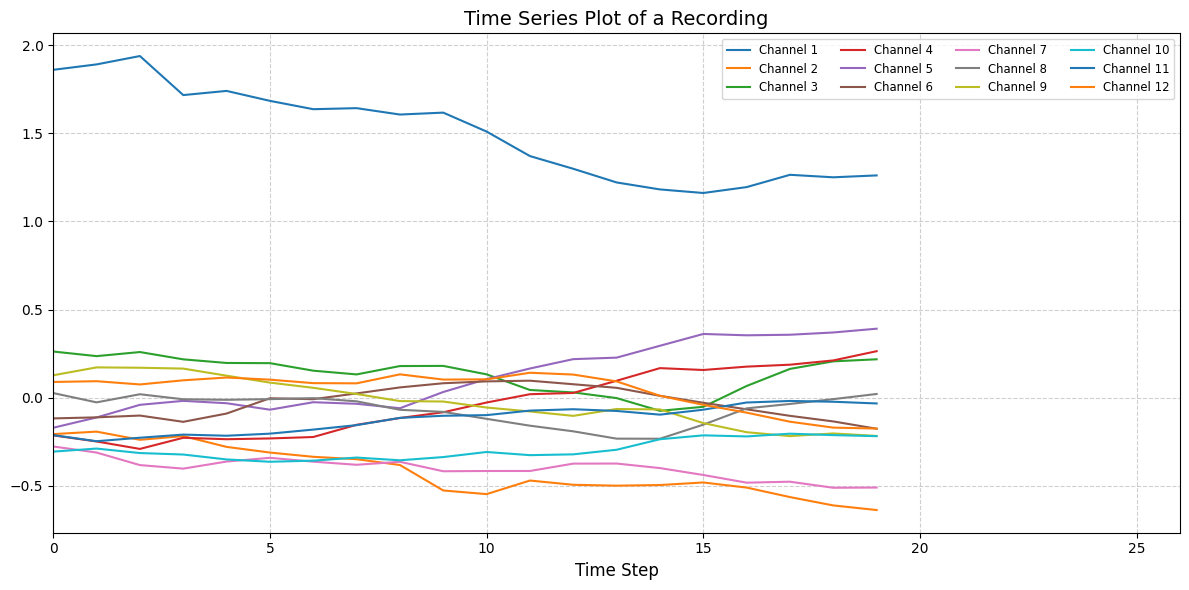

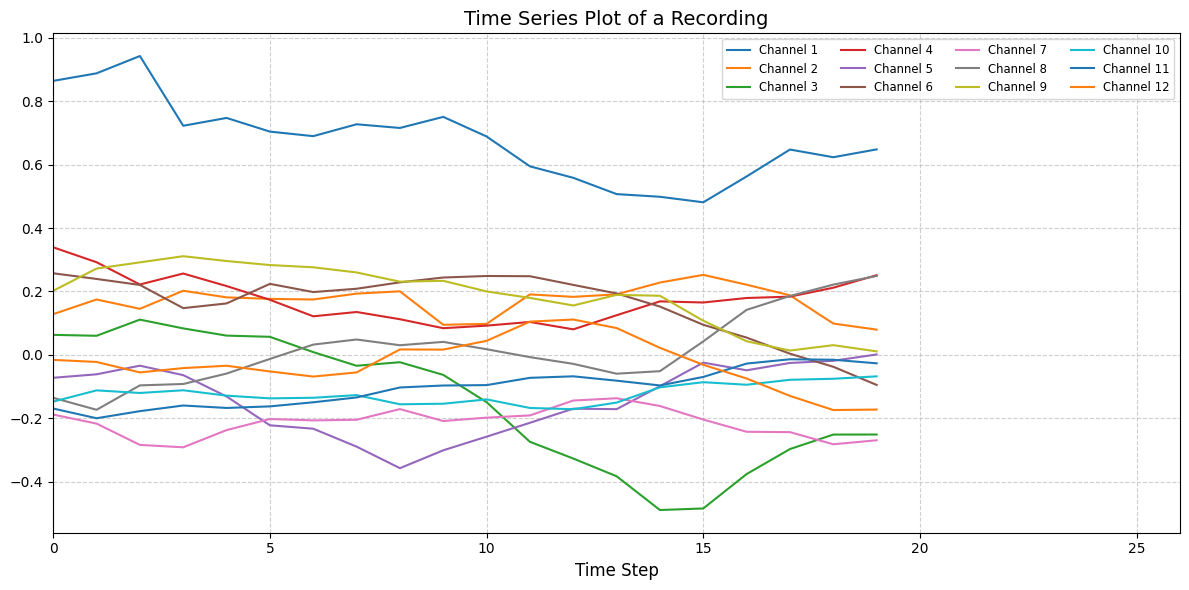

In [86]:
visualize_data_point(train_data[0])

# this procedure normalizes the training data
for data_point in train_data:
    for time_step in range(train_time_steps):
        if np.count_nonzero(data_point[time_step]) > 0:
            data_point[time_step] -= pattern_mean[time_step]

visualize_data_point(train_data[0])